# Project-3-BQuery-Pol-Advertising-Data

## Pick a dataset that interests you (or multiple data sets)

Use the Open Data Sets available from Google BigQuery. You can use your own Google account or Kaggle.



# Imports

In [218]:
%%capture
# pandas module
import pandas as pd
import pandas_gbq

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker


# gcp modules
from google.cloud import bigquery

# colab modules
from google.colab import auth
from google.colab import syntax
from google.colab import userdata

# Authentication

In [162]:
auth.authenticate_user()
print('Authenticated')

Authenticated


# Enable Data Table Entry

In [163]:
%load_ext google.colab.data_table
# %unload_ext google.colab.data_table

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


# List Projects

In [164]:
%alias gcloud gcloud

In [165]:
%%capture
gcloud projects list --sort-by=projectId

In [166]:
project_id = userdata.get('proj-3')

Based on the outputs you provided, here are the answers to your questions:

1. How many rows are in the full dataset?
The full dataset contains 1,814,759 rows.

2. How many columns are in the full dataset?
The number of columns varies by table. For example:
- geo_spend has 23 columns
- advertiser_stats has 26 columns
- creative_stats has 56 columns

3. What tables are available in the google_political_ads dataset?
The available tables include:
- geo_spend
- advertiser_stats
- advertiser_weekly_spend
- advertiser_declared_stats
- last_updated
- advertiser_geo_spend
- campaign_targeting
- top_keywords_history
- creative_stats

4. What columns are available in the google_political_ads dataset?
The columns vary by table, but some common columns include:
- advertiser_id
- advertiser_name
- regions
- date_range_start
- date_range_end
- num_of_days
- impressions
- spend_usd
- spend_range_min_usd
- spend_range_max_usd

5. Which advertisers have spent the most money on political ads?
The top advertisers by spending include:
- Biden for President
- Donald J. Trump for President, Inc.
- Mike Bloomberg 2020 Inc.
- Harris Victory Fund
- Trump Make America Great Again Committee

6. How much have specific advertisers (Biden and Trump campaigns) spent on political ads?
The total spending for Biden and Trump campaigns combined is $97,200.

7. What is the total spending of Biden and Trump campaigns combined?
The total spending for Biden and Trump campaigns combined is $97,200.

8. What is the average spending of Biden and Trump campaigns?
The average spending for Biden and Trump campaigns is $1,495.38.

9. How has spending changed over time for a specific advertiser?
The spending trend over time for specific advertisers is not provided in the output, but the query to calculate this is shown.

10. What is the sum of all spending across all advertisers?
The sum of all spending across all advertisers is $1,733,853,600.

11. What is the average spending across all advertisers?
The average spending across all advertisers is $1,237.21.

12. What is the median spending across all advertisers?
The median spending across all advertisers is $100.

13. What are the spending percentiles (1st, 10th, 25th, 50th, 75th, 90th, 99th) across all advertisers?
The spending percentiles are:
- 1st percentile: $100

- 10th percentile: $100

- 25th percentile: $100

- 50th percentile: $100

- 75th percentile: $100

- 90th percentile: $100

- 99th percentile: $900

14. What are the minimum and maximum spending amounts across all advertisers?
The minimum spending amount is $0, and the maximum spending amount is $3,000,000.

15. What are the unique advertiser names in the dataset?
The unique advertiser names are not provided in the output, but the query to find these is shown.

16. What is the maximum spending across all advertisers?
The maximum spending across all advertisers is $3,000,000.

17. How does the spending trend compare between Biden and Trump campaigns over time?
The spending trend comparison between Biden and Trump campaigns over the recent election season has near 0. This shows that more research needs to be done about non Trump and non Biden named advertisers.

### Independant Python Aliases

In [167]:
client = bigquery.Client(project=project_id)


In [168]:
THREE_GB = 3 * 1_000 * 1_000 * 1_000 * 1_000
SIX_GB = 6 * 1_000 * 1_000 * 1_000 * 1_000
TEN_GB = 10 * 1_000 * 1_000 * 1_000 * 1_000


### Basic Queries


In [169]:
row_count = client.query('''
  SELECT
    COUNT(1) as total
  FROM `bigquery-public-data.google_political_ads.creative_stats`
  '''
).to_dataframe()["total"][0]

print(f'Full dataset has {row_count:_} rows')

Full dataset has 1_814_759 rows


In [170]:
column_count = client.query('''
  SELECT COUNT(column_name) as total
  FROM `bigquery-public-data`.google_political_ads.INFORMATION_SCHEMA.COLUMNS
  WHERE table_name = 'creative_stats'
''').to_dataframe()["total"][0]
print(f'Full dataset has {column_count:_} columns')


Full dataset has 56 columns


In [171]:
tables = client.query('''
    SELECT table_name
    FROM `bigquery-public-data`.google_political_ads.INFORMATION_SCHEMA.TABLES
''').to_dataframe()

for table in tables['table_name']:
    column_count = client.query(f'''
        SELECT COUNT(column_name) as total
        FROM `bigquery-public-data`.google_political_ads.INFORMATION_SCHEMA.COLUMNS
        WHERE table_name = '{table}'
    ''').to_dataframe()["total"][0]
    print(f'Table {table} has {column_count:_} columns')

Table geo_spend has 23 columns
Table advertiser_stats has 26 columns
Table advertiser_weekly_spend has 24 columns
Table advertiser_declared_stats has 7 columns
Table last_updated has 1 columns
Table advertiser_geo_spend has 24 columns
Table campaign_targeting has 10 columns
Table top_keywords_history has 16 columns
Table creative_stats has 56 columns


In [172]:
schema = client.query('''
  SELECT table_name
  FROM `bigquery-public-data`.google_political_ads.INFORMATION_SCHEMA.TABLES
''').to_dataframe()
schema

table_name
0                  geo_spend
1           advertiser_stats
2    advertiser_weekly_spend
3  advertiser_declared_stats
4               last_updated
5       advertiser_geo_spend
6         campaign_targeting
7       top_keywords_history
8             creative_stats

# advstats = advertiser_stats table

In [173]:
# what are the sum and average of spending by advertisers
advstats = client.query('''
SELECT
    as_.advertiser_id,
    as_.advertiser_name,
    as_.regions,
    SUM(cs.spend_range_min_usd) AS total_spend,
    AVG(cs.spend_range_min_usd) AS avg_spend
  FROM
    `bigquery-public-data.google_political_ads.advertiser_stats` AS as_
    INNER JOIN `bigquery-public-data.google_political_ads.creative_stats` AS cs ON as_.advertiser_id = cs.advertiser_id
  GROUP BY
    as_.advertiser_id, as_.advertiser_name, as_.regions
  ORDER BY total_spend DESC
''').to_dataframe()

In [174]:
advstats

advertiser_id  \
0      AR12365610929977556993   
1      AR11825178974693097473   
2      AR09516581413973917697   
3      AR10462168114010259457   
4      AR07331491169769095169   
...                       ...   
19803  AR02348775158707126273   
19804  AR17196428413229858817   
19805  AR08567105569511440385   
19806  AR01960542550741745665   
19807  AR08021386337686913025   

                                         advertiser_name regions  total_spend  \
0                                    BIDEN FOR PRESIDENT      US     89154100   
1                    DONALD J. TRUMP FOR PRESIDENT, INC.      US     76284700   
2                                MIKE BLOOMBERG 2020 INC      US     54533600   
3                                    HARRIS VICTORY FUND      US     54434200   
4               TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      US     42654800   
...                                                  ...     ...          ...   
19803                                  Fernando Cruzetta      BR            0   
19804                                     Publica Online      AR            0   
19805                                       manish Verma      IN            0   
19806  PROTECT PASADENA'S LIBRARIES 2022 MEASURE A SU...      US            0   
19807                                  HUNT FOR CONGRESS      US            0   

          avg_spend  
0       1416.763603  
1       2791.346189  
2        850.240883  
3      26398.739088  
4        992.479873  
...             ...  
19803      0.000000  
19804      0.000000  
19805      0.000000  
19806      0.000000  
19807      0.000000  

[19808 rows x 5 columns]

# cstats =creative_stats table

In [175]:
# What data types are the rows in the table?
cstats = client.query('''
  SELECT column_name, data_type
  FROM `bigquery-public-data`.google_political_ads.INFORMATION_SCHEMA.COLUMNS
  WHERE table_name = 'creative_stats'
''').to_dataframe()

In [176]:
cstats

column_name  data_type
0                    ad_id     STRING
1                   ad_url     STRING
2                  ad_type     STRING
3                  regions     STRING
4            advertiser_id     STRING
5          advertiser_name     STRING
6        ad_campaigns_list     STRING
7         date_range_start       DATE
8           date_range_end       DATE
9              num_of_days      INT64
10             impressions     STRING
11               spend_usd     STRING
12  first_served_timestamp  TIMESTAMP
13   last_served_timestamp  TIMESTAMP
14           age_targeting     STRING
15        gender_targeting     STRING
16  geo_targeting_included     STRING
17  geo_targeting_excluded     STRING
18     spend_range_min_usd      INT64
19     spend_range_max_usd      INT64
20     spend_range_min_eur      INT64
21     spend_range_max_eur      INT64
22     spend_range_min_inr      INT64
23     spend_range_max_inr      INT64
24     spend_range_min_bgn      INT64
25     spend_range_max_bgn      INT64
26     spend_range_min_czk      INT64
27     spend_range_max_czk      INT64
28     spend_range_min_dkk      INT64
29     spend_range_max_dkk      INT64
30     spend_range_min_huf      INT64
31     spend_range_max_huf      INT64
32     spend_range_min_pln      INT64
33     spend_range_max_pln      INT64
34     spend_range_min_ron      INT64
35     spend_range_max_ron      INT64
36     spend_range_min_sek      INT64
37     spend_range_max_sek      INT64
38     spend_range_min_gbp      INT64
39     spend_range_max_gbp      INT64
40     spend_range_min_nzd      INT64
41     spend_range_max_nzd      INT64
42     spend_range_min_ils      INT64
43     spend_range_max_ils      INT64
44     spend_range_min_aud      INT64
45     spend_range_max_aud      INT64
46     spend_range_min_twd      INT64
47     spend_range_max_twd      INT64
48     spend_range_min_brl      INT64
49     spend_range_max_brl      INT64
50     spend_range_min_ars      INT64
51     spend_range_max_ars      INT64
52     spend_range_min_zar      INT64
53     spend_range_max_zar      INT64
54     spend_range_min_clp      INT64
55     spend_range_max_clp      INT64

#### SELECT (with * and with column names)
How much has each advertiser spent

In [177]:
# Select all columns from the advertiser_stats table
all_columns = client.query('''
    SELECT *
    FROM `bigquery-public-data.google_political_ads.advertiser_stats`
    LIMIT 100
''').to_dataframe()
all_columns

advertiser_id                                    advertiser_name  \
0   AR18101017142164979713             PARTIDO JUSTICIALISTA DISTRITO TUCUMAN   
1   AR08056822016902168577                            Partido Obrero Santa Fe   
2   AR16856365306598129665      PRO PROPUESTA REPUBLICANA DISTRITO ENTRE RIOS   
3   AR10541413181199220737                                 Unión Por San Luis   
4   AR13330527937783398401                                 Performance Online   
..                     ...                                                ...   
95  AR08815463702670082049  Asociación Civil Centro de Estudios e Investig...   
96  AR08257843631864414209                              Maria Lorena Lorefice   
97  AR10226310569065971713                                    Lorena Lorefice   
98  AR10298995331408330753                                Frente Cambia Jujuy   
99  AR06005043022079721473                                             Petrun   

   public_ids_list regions elections  total_creatives  spend_usd  spend_eur  \
0             None      AR      None              114          0          0   
1             None      AR      None              155          0          0   
2             None      AR      None              141          0          0   
3             None      AR      None              258          0          0   
4             None      AR      None              522          0          0   
..             ...     ...       ...              ...        ...        ...   
95            None      AR      None               79          0          0   
96            None      AR      None               71          0          0   
97            None      AR      None              106          0          0   
98            None      AR      None               34          0          0   
99            None      AR      None              286          0          0   

    spend_inr  spend_bgn  ...  spend_sek  spend_gbp  spend_nzd  spend_ils  \
0           0          0  ...          0          0          0          0   
1           0          0  ...          0          0          0          0   
2           0          0  ...          0          0          0          0   
3           0          0  ...          0          0          0          0   
4           0          0  ...          0          0          0          0   
..        ...        ...  ...        ...        ...        ...        ...   
95          0          0  ...          0          0          0          0   
96          0          0  ...          0          0          0          0   
97          0          0  ...          0          0          0          0   
98          0          0  ...          0          0          0          0   
99          0          0  ...          0          0          0          0   

    spend_aud  spend_twd  spend_brl  spend_ars  spend_zar  spend_clp  
0           0          0          0    8265000          0          0  
1           0          0          0    1125000          0          0  
2           0          0          0     975000          0          0  
3           0          0          0   18945000          0          0  
4           0          0          0   80670000          0          0  
..        ...        ...        ...        ...        ...        ...  
95          0          0          0     135000          0          0  
96          0          0          0    2130000          0          0  
97          0          0          0    1800000          0          0  
98          0          0          0    4170000          0          0  
99          0          0          0   20610000          0          0  

[100 rows x 26 columns]

#### LIMIT



In [178]:
# Using LIMIT to show the first 5 rows of the advertiser_stats table
limited_rows = client.query('''
    SELECT *
    FROM `bigquery-public-data.google_political_ads.advertiser_stats`
    LIMIT 5
''').to_dataframe()
limited_rows

advertiser_id                                advertiser_name  \
0  AR18101017142164979713         PARTIDO JUSTICIALISTA DISTRITO TUCUMAN   
1  AR08056822016902168577                        Partido Obrero Santa Fe   
2  AR16856365306598129665  PRO PROPUESTA REPUBLICANA DISTRITO ENTRE RIOS   
3  AR10541413181199220737                             Unión Por San Luis   
4  AR13330527937783398401                             Performance Online   

  public_ids_list regions elections  total_creatives  spend_usd  spend_eur  \
0            None      AR      None              114          0          0   
1            None      AR      None              155          0          0   
2            None      AR      None              141          0          0   
3            None      AR      None              258          0          0   
4            None      AR      None              522          0          0   

   spend_inr  spend_bgn  ...  spend_sek  spend_gbp  spend_nzd  spend_ils  \
0          0          0  ...          0          0          0          0   
1          0          0  ...          0          0          0          0   
2          0          0  ...          0          0          0          0   
3          0          0  ...          0          0          0          0   
4          0          0  ...          0          0          0          0   

   spend_aud  spend_twd  spend_brl  spend_ars  spend_zar  spend_clp  
0          0          0          0    8265000          0          0  
1          0          0          0    1125000          0          0  
2          0          0          0     975000          0          0  
3          0          0          0   18945000          0          0  
4          0          0          0   80670000          0          0  

[5 rows x 26 columns]

### AND, FROM, WHERE, GROUP BY,


In [179]:
# Find the total spending of Biden and Trump campaigns combined.
biden_trump_spending = client.query('''
    SELECT
        SUM(cs.spend_range_max_usd) AS total_spend
    FROM
        `bigquery-public-data.google_political_ads.advertiser_stats` AS as_
        INNER JOIN `bigquery-public-data.google_political_ads.creative_stats` AS cs ON as_.advertiser_id = cs.advertiser_id
    WHERE
        as_.advertiser_name LIKE '%Biden%' OR as_.advertiser_name LIKE '%Trump%'
''').to_dataframe()

biden_trump_spending

total_spend
0        97200

### AND, LIKE (with % or _ wildcard)


In [180]:
# Calculate the average spending of Biden and Trump campaigns.
biden_trump_avg_spending = client.query('''
    SELECT
        AVG(cs.spend_range_max_usd) AS avg_spend
    FROM
        `bigquery-public-data.google_political_ads.advertiser_stats` AS as_
        INNER JOIN `bigquery-public-data.google_political_ads.creative_stats` AS cs ON as_.advertiser_id = cs.advertiser_id
    WHERE
        as_.advertiser_name LIKE '%Biden%' OR as_.advertiser_name LIKE '%Trump%'
''').to_dataframe()

biden_trump_avg_spending

avg_spend
0  1495.384615

#### ORDER BY, GROUP BY


In [181]:
client.query('''
SELECT
    cs1.advertiser_name AS advertiser1,
    cs2.advertiser_name AS advertiser2,
    SUM(cs1.spend_range_min_usd) AS total_spend_1,
    SUM(cs2.spend_range_min_usd) AS total_spend_2
  FROM
    `bigquery-public-data.google_political_ads.creative_stats` AS cs1
    INNER JOIN `bigquery-public-data.google_political_ads.creative_stats` AS cs2 ON cs1.advertiser_name != cs2.advertiser_name
  WHERE cs1.advertiser_name IN ('BIDEN FOR PRESIDENT', 'HARRIS VICTORY FUND', 'HARRIS FOR PRESIDENT', 'BIDEN VICTORY FUND')
   AND cs2.advertiser_name IN ('DONALD J. TRUMP FOR PRESIDENT, INC', 'TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE')
  GROUP BY advertiser1, advertiser2
ORDER BY total_spend_1 DESC, total_spend_2 DESC
''').to_dataframe()

advertiser1                               advertiser2  \
0   BIDEN FOR PRESIDENT  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
1   HARRIS VICTORY FUND  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
2  HARRIS FOR PRESIDENT  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   
3    BIDEN VICTORY FUND  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE   

   total_spend_1  total_spend_2  
0  3831664909800  2684181254400  
1  2339473047600    87954197600  
2  1661808837000   496416562400  
3  1313429169000   154495685600

#### SUM


In [182]:
# Calculate the sum of 'spend_range_min_usd' for all rows in the 'creative_stats' table.

sum_spend = client.query('''
    SELECT SUM(spend_range_min_usd) AS total_spending
    FROM `bigquery-public-data.google_political_ads.creative_stats`
''').to_dataframe()

sum_spend

total_spending
0      1733853600

#### AVG


In [183]:
# Calculate the average spending across all advertisers.
avg_spending_all = client.query('''
    SELECT AVG(spend_range_max_usd) AS avg_spend
    FROM `bigquery-public-data.google_political_ads.creative_stats`
''').to_dataframe()

avg_spending_all

avg_spend
0  1237.213206

In [184]:
median_spending = client.query('''
    SELECT APPROX_QUANTILES(spend_range_max_usd, 100)[OFFSET(50)] AS median_spend
    FROM `bigquery-public-data.google_political_ads.creative_stats`
''').to_dataframe()

median_spending

median_spend
0           100

In [185]:
percentile_spending = client.query('''
    SELECT
        PERCENTILE_CONT(spend_range_max_usd, 0.01) OVER() AS percentile_1,
        PERCENTILE_CONT(spend_range_max_usd, 0.10) OVER() AS percentile_10,
        PERCENTILE_CONT(spend_range_max_usd, 0.25) OVER() AS percentile_25,
        PERCENTILE_CONT(spend_range_max_usd, 0.50) OVER() AS percentile_50,
        PERCENTILE_CONT(spend_range_max_usd, 0.75) OVER() AS percentile_75,
        PERCENTILE_CONT(spend_range_max_usd, 0.90) OVER() AS percentile_90,
        PERCENTILE_CONT(spend_range_max_usd, 0.99) OVER() AS percentile_99
    FROM
        `bigquery-public-data.google_political_ads.creative_stats`
    LIMIT 1
''').to_dataframe()

percentile_spending

percentile_1  percentile_10  percentile_25  percentile_50  percentile_75  \
0         100.0          100.0          100.0          100.0          100.0   

   percentile_90  percentile_99  
0          900.0        20000.0

In [186]:
spend_min_usd = client.query('''
SELECT
  MIN(spend_range_min_usd) AS min_spend_min_usd,
  MAX(spend_range_min_usd) AS max_spend_min_usd,
  AVG(spend_range_min_usd) AS avg_spend_min_usd
FROM `bigquery-public-data.google_political_ads.creative_stats`
''').to_dataframe()
spend_min_usd

min_spend_min_usd  max_spend_min_usd  avg_spend_min_usd
0                  0            3000000         955.418102

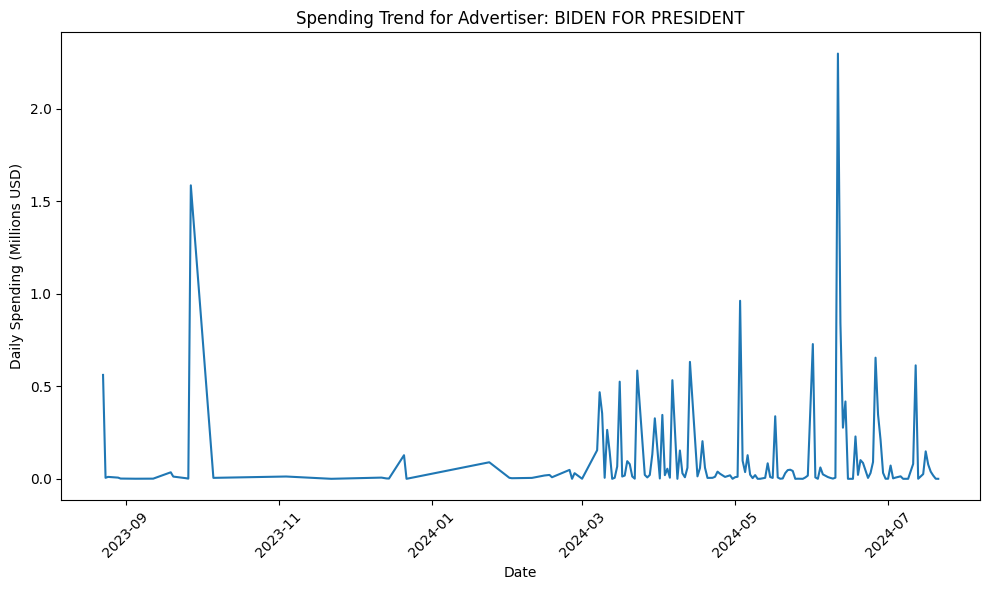

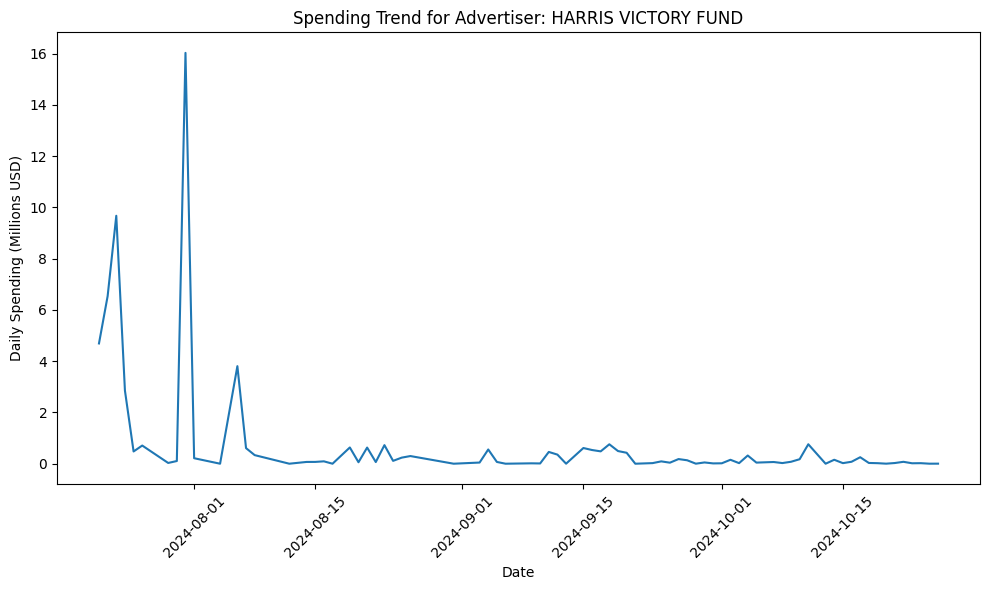

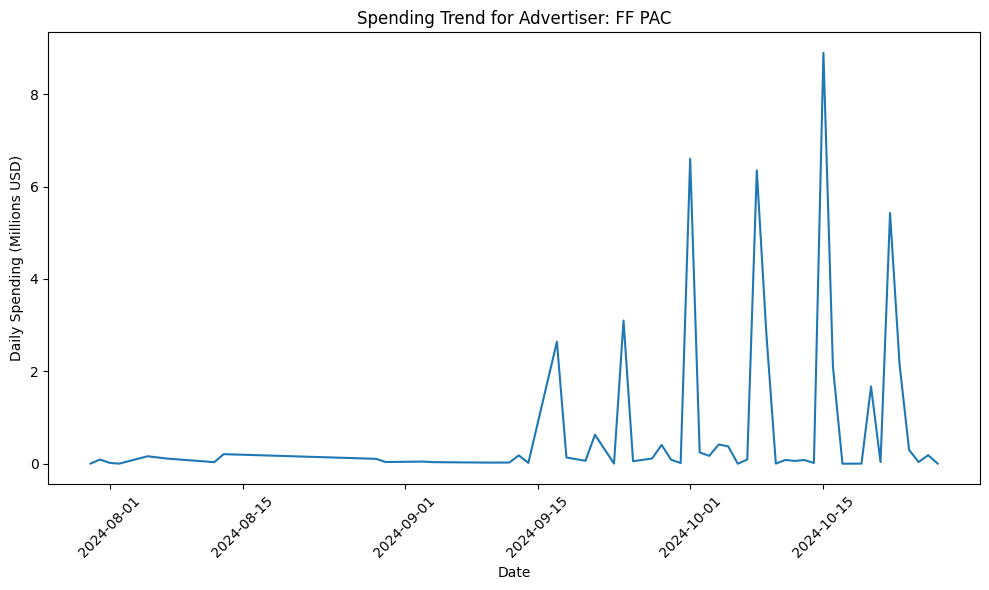

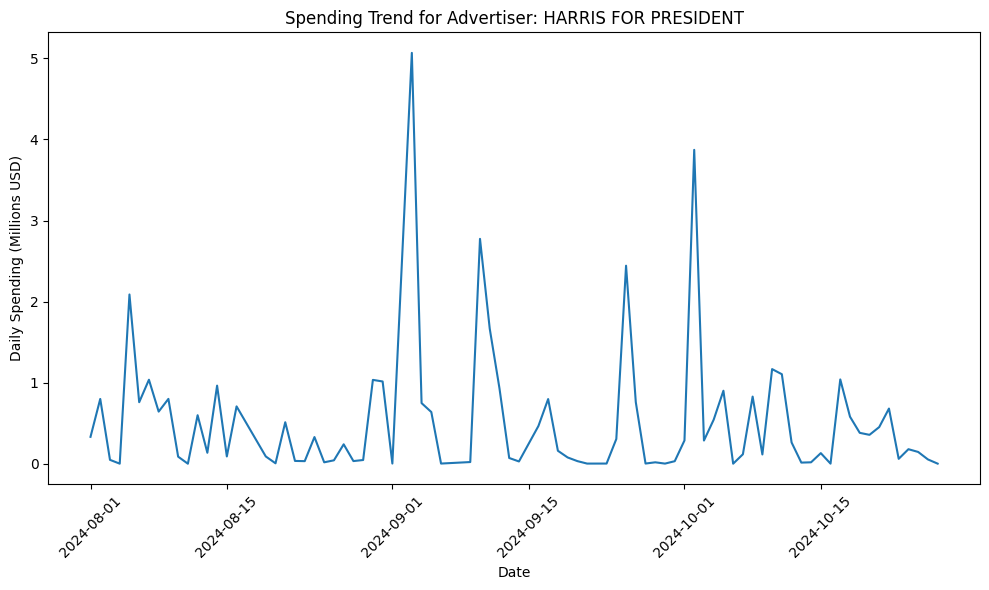

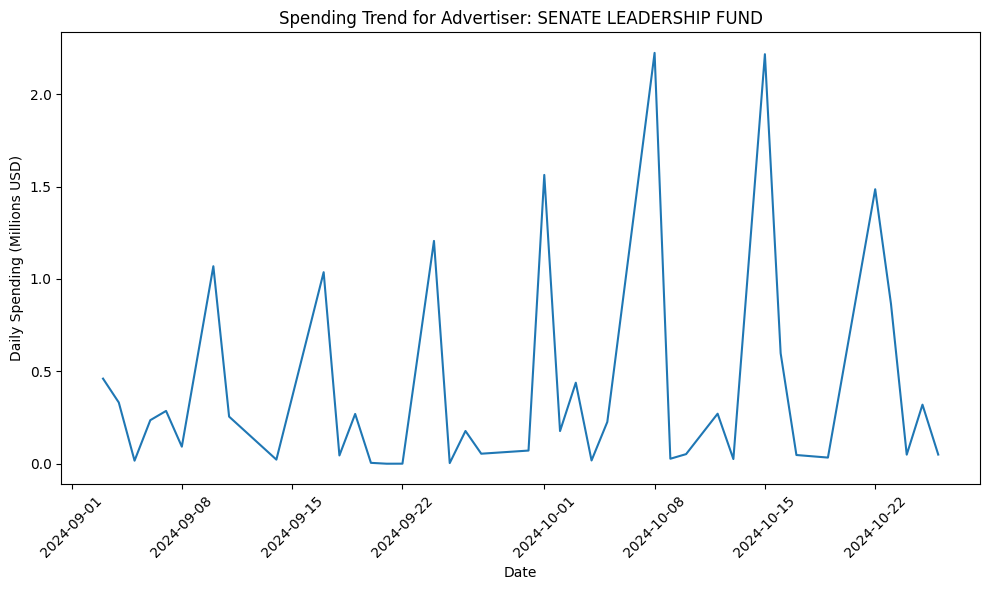

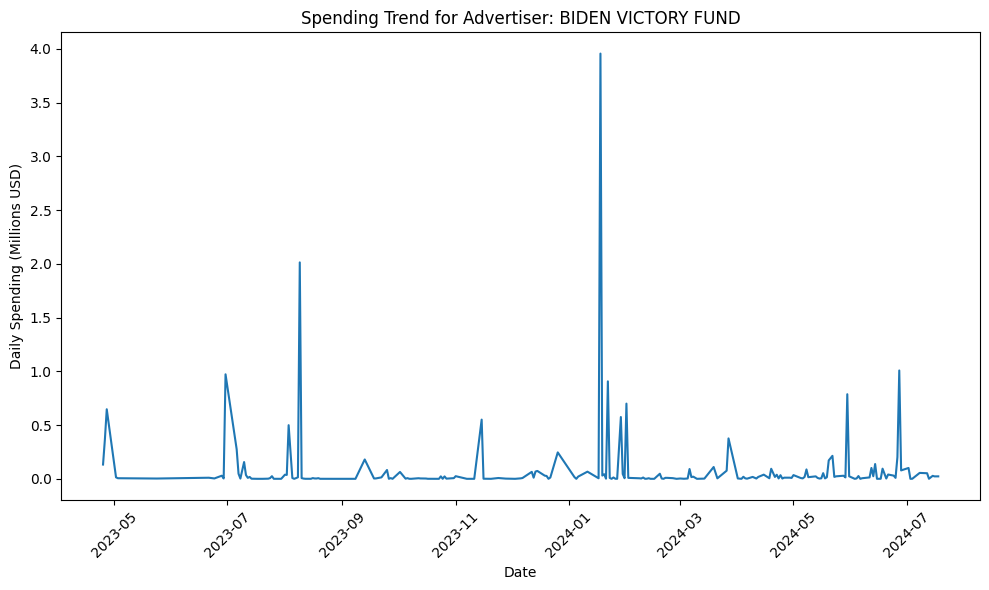

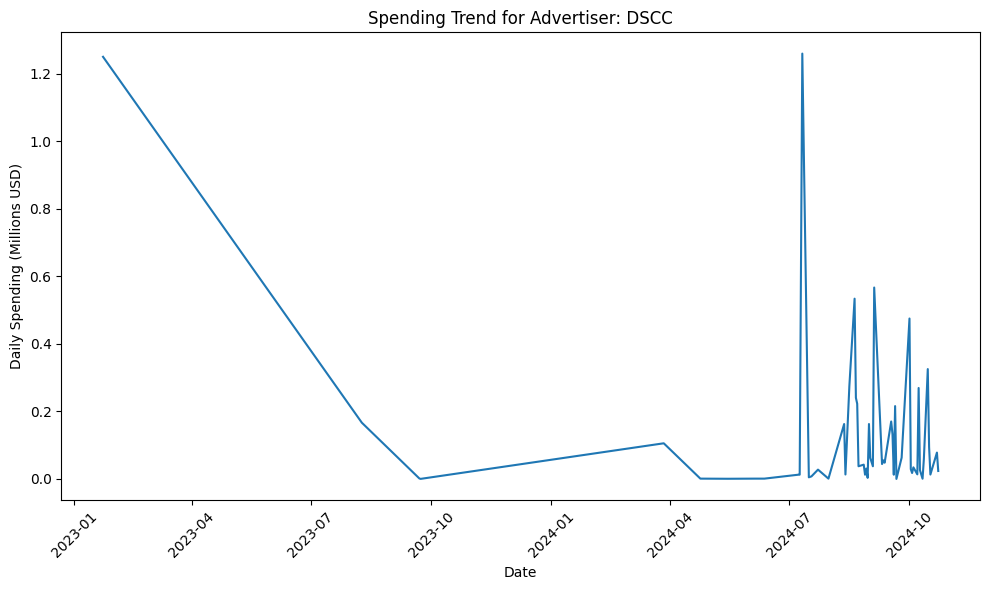

In [187]:
# Focus on Top Spenders
for index, row in top_advertisers.iterrows():
    advertiser_id = row['advertiser_id']
    advertiser_name = row['advertiser_name']

    advertiser_spending = client.query(f"""
        SELECT
            t1.date_range_start AS date,
            SUM((t1.spend_range_min_usd + t1.spend_range_max_usd) / 2) / 1000000 AS daily_spend_millions,  # Total spending in millions
            t2.advertiser_name
        FROM
            `bigquery-public-data.google_political_ads.creative_stats` AS t1
        INNER JOIN
            `bigquery-public-data.google_political_ads.advertiser_stats` AS t2
            ON t1.advertiser_id = t2.advertiser_id
        WHERE t1.advertiser_id = '{advertiser_id}'
        AND t1.date_range_start BETWEEN '2023-01-01' AND '2024-12-31'
        GROUP BY
            date, t2.advertiser_name
        ORDER BY
            date
    """).to_dataframe()

    if not advertiser_spending.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(advertiser_spending['date'], advertiser_spending['daily_spend_millions'])  # Plot total spending in millions
        plt.xlabel('Date')
        plt.ylabel('Daily Spending (Millions USD)')
        plt.title(f'Spending Trend for Advertiser: {advertiser_name}')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt

#### DISTINCT


In [188]:
# Example using DISTINCT to find unique advertiser names
distinct_advertisers = client.query('''
    SELECT DISTINCT advertiser_name
    FROM `bigquery-public-data.google_political_ads.advertiser_stats`
    LIMIT 100
''').to_dataframe()

distinct_advertisers

advertiser_name
0              PARTIDO JUSTICIALISTA DISTRITO TUCUMAN
1                             Partido Obrero Santa Fe
2       PRO PROPUESTA REPUBLICANA DISTRITO ENTRE RIOS
3                                  Unión Por San Luis
4                                  Performance Online
..                                                ...
95  Asociación Civil Centro de Estudios e Investig...
96                              Maria Lorena Lorefice
97                                    Lorena Lorefice
98                                Frente Cambia Jujuy
99                                             Petrun

[100 rows x 1 columns]

### Aggregates


In [234]:
biden_harris_spending = client.query('''
SELECT
    as_.advertiser_name,
    aws.week_start_date AS spending_date,
    SUM(aws.spend_usd) AS total_spend
  FROM
    `bigquery-public-data.google_political_ads.advertiser_stats` AS as_
    INNER JOIN `bigquery-public-data.google_political_ads.advertiser_weekly_spend` AS aws ON as_.advertiser_id = aws.advertiser_id
  WHERE as_.advertiser_name IN ('BIDEN FOR PRESIDENT', 'HARRIS VICTORY FUND', 'HARRIS FOR PRESIDENT', 'BIDEN VICTORY FUND')
  GROUP BY as_.advertiser_name, aws.week_start_date
  ORDER BY aws.week_start_date, as_.advertiser_name
''').to_dataframe()


In [235]:
biden_harris_spending



advertiser_name spending_date  total_spend
0     BIDEN FOR PRESIDENT    2019-04-21       362900
1     BIDEN FOR PRESIDENT    2019-04-28       120700
2     BIDEN FOR PRESIDENT    2019-05-05        60100
3     BIDEN FOR PRESIDENT    2019-05-12        20500
4     BIDEN FOR PRESIDENT    2019-05-19         3000
..                    ...           ...          ...
237   HARRIS VICTORY FUND    2024-10-06      1591700
238  HARRIS FOR PRESIDENT    2024-10-13      4007600
239   HARRIS VICTORY FUND    2024-10-13      2527700
240  HARRIS FOR PRESIDENT    2024-10-20      4975500
241   HARRIS VICTORY FUND    2024-10-20      1820700

[242 rows x 3 columns]

In [239]:
biden_harris_total_spending = biden_harris_spending['total_spend'].sum()

print(f"Total Biden/Harris campaign ad spending: ${biden_harris_total_spending:,.2f} on Google services")


Total Biden/Harris campaign ad spending: $239,909,000.00 on Google services


In [240]:
trump_spending= client.query('''
SELECT
    as_.advertiser_name,
    aws.week_start_date,
    SUM(aws.spend_usd) AS trump_total_spend
  FROM
    `bigquery-public-data.google_political_ads.advertiser_stats` AS as_
    INNER JOIN `bigquery-public-data.google_political_ads.advertiser_weekly_spend` AS aws ON as_.advertiser_id = aws.advertiser_id
  WHERE as_.advertiser_name IN ('DONALD J. TRUMP FOR PRESIDENT, INC', 'TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE', 'SAVE AMERICA JFC', 'MAKE AMERICA GREAT AGAIN, AGAIN! INC.', 'SAVE AMERICA')
  GROUP BY as_.advertiser_name, aws.week_start_date
  ORDER BY as_.advertiser_name, aws.week_start_date
''').to_dataframe()

In [241]:
trump_spending

advertiser_name week_start_date  \
0    TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2018-05-27   
1    TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2018-06-03   
2    TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2018-06-10   
3    TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2018-06-17   
4    TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2018-06-24   
..                                        ...             ...   
125  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2020-10-18   
126  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2020-10-25   
127  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2020-11-01   
128  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2020-12-06   
129  TRUMP MAKE AMERICA GREAT AGAIN COMMITTEE      2020-12-13   

     trump_total_spend  
0                14100  
1                43500  
2                77900  
3                53900  
4                48900  
..                 ...  
125            1064800  
126             404600  
127             143200  
128               7900  
129                900  

[130 rows x 3 columns]

In [243]:
print(trump_spending.columns)


Index(['advertiser_name', 'week_start_date', 'trump_total_spend'], dtype='object')


In [246]:
trump_total_spending = trump_spending['trump_total_spend'].sum()

print(f"Total Trump campaign ad spending: ${trump_total_spending:,.2f} on Google services")


Total Trump campaign ad spending: $47,695,200.00 on Google services


<Figure size 1200x600 with 0 Axes>

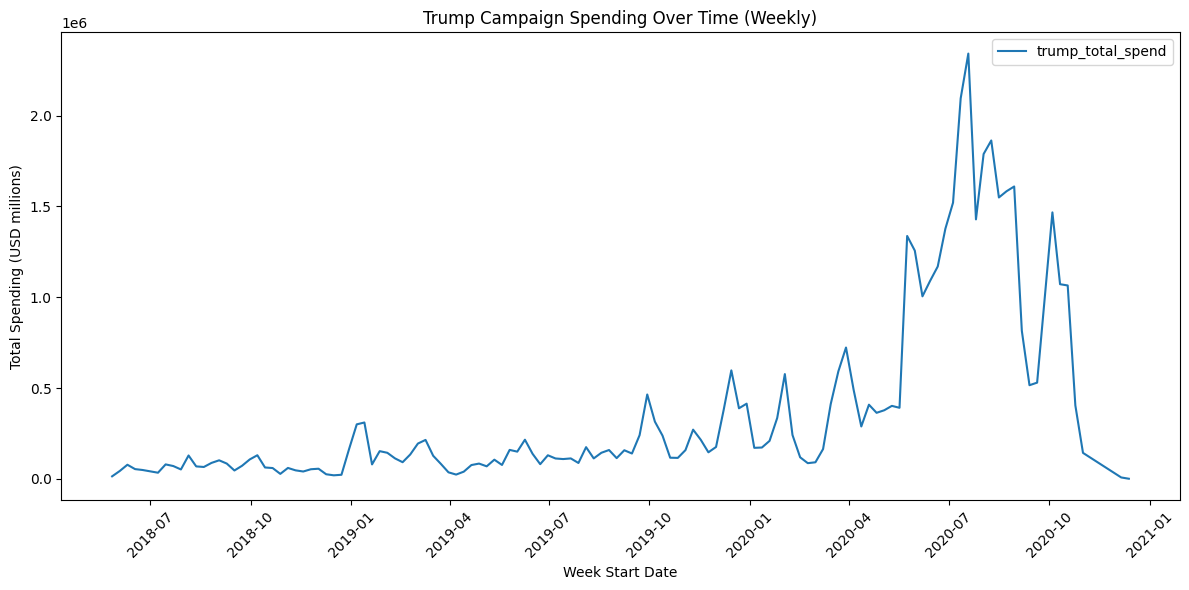

<Figure size 1400x800 with 0 Axes>

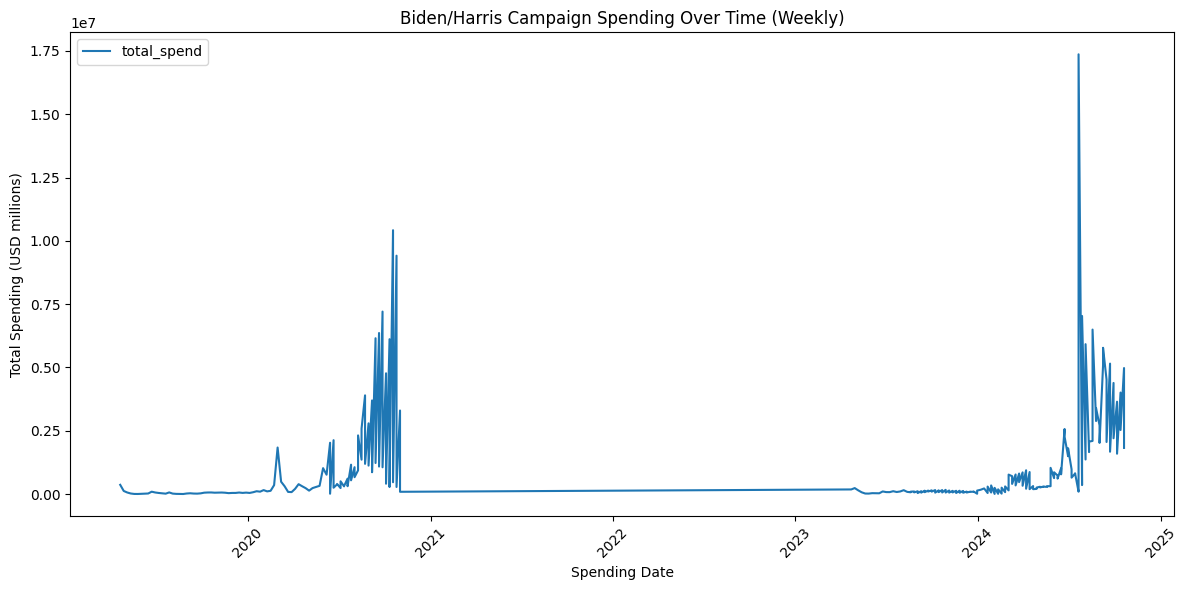

In [250]:
# Plot Trump spending
plt.figure(figsize=(12, 6))
trump_spending.plot(x='week_start_date', y='trump_total_spend', figsize=(12, 6))
plt.title('Trump Campaign Spending Over Time (Weekly)')
plt.xlabel('Week Start Date')
plt.ylabel('Total Spending (USD millions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot Biden/Harris spending
plt.figure(figsize=(14, 8))
biden_harris_spending.plot(x='spending_date', y='total_spend', figsize=(12, 6))
plt.title('Biden/Harris Campaign Spending Over Time (Weekly)')
plt.xlabel('Spending Date')
plt.ylabel('Total Spending (USD millions)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
